# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

# Задачи 

Необходимо провести анализ и подготовить план действий по удержанию клиентов, а именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;

  2) предложить меры по снижению оттока;

  3) определить другие особенности взаимодействия с клиентами.

## Загрузим данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


import warnings #игнор ошибок
warnings.simplefilter("ignore")

In [2]:
try:
    gym = pd.read_csv('gym_churn.csv')
except:
    gym = pd.read_csv('/datasets/gym_churn.csv')
    
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Файл включает в себя следующие поля:**

* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

### Посмотрим есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения.

In [3]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

Отличный и удобный формат таблицы 👍

</div>

Посмотрим, какие выводы мы можем сделать исходя из полученной таблицы выше:
* Распределение по полу практически одинаково;
* Около 85% живет или работает в районе, где находится фитнес-клуб;
* Около 49% клиентов являются сотрудниками партнерских организаций и имеют скидки;
* Примерно 31% клиентов пришли по приглашению друзей, акция "Приведи друга";
* Оставили свои мобильные номера в анкете примерно 90% клиентов;
* Средняя длительность действующих абонементов примерно 5 месяцев;
* 41% клиентов посещают групповые занятия;
* Средний возраст клиентов 29 лет;
* Средняя дополнительная выручка с клиента - 146 у.е;
* Средний срок до окончания договора - 4 месяца;
* Среднее время с момента первого посещения в фитнес-центр - 4 месяца;
* Средняя частота посещений за все время - меньше 2 раз в неделю (1.88);
* Средняя частота посещений за последний месяц - 1.76 раз в неделю;
* **Доля оттока - около 27%**

Также проверим типы данных, посмотрим есть ли дубликаты и пустые значения, заменим названия столбцов на более корректные.

In [4]:
gym.columns = gym.columns.str.lower()

In [5]:
gym.info()
#print(gym.isna().mean() * 100)
#print(gym.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

В датасете отсутствуют пропуски и дубликаты. Все типы данных соответствуют значениям. Данные готовы для дальнейшего анализа.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
gym.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Посмотрим, в каких признаках есть отличия:
* Распределение по полу одинаково, т.е. мужчины и женщины одинаково любят и не любят спортзал;
* Около 87% оставшихся клиентов живет или работает в районе, где находится фитнес-клуб, среди ушедших клиентов значение меньше на 10%;
* 53% клиентов являются сотрудниками партнерских организаций и имеют скидки, в оттоке таких клиентов 35%;
* Примерно 35% действующих клиентов пришли по приглашению друзей, в то время среди ушедших таких клиентов всего 18%;
* Оставили свои мобильные номера в анкете примерно 90% клиентов в обеих группах;
* Средняя длительность действующих абонементов оставшихся клиентов почти 6 месяцев, а в оттоке около 2-х;
* 46% действующих клиентов посещают групповые занятия, среди ушедших клиентов посещали групповые занятия всего 27%;
* Средний возраст клиентов оставшихся - 30 лет, а ушедших - 27;
* Средняя дополнительная выручка с клиента - 158 у.е, дополнительная выручка с ушедшего клиента составляла в среднем - 115 у.е;
* Средний срок до окончания договора  у клиентов - 5 месяцев, среди ушедших это 1.5 - 2 месяца;
* Среднее время с момента первого посещения оставшихся клиентов - около 5 месяцев, для ушедших - это 1 месяц;
* Средняя частота посещений оставшихся клиентов за все время - 2 раза в неделю, клиенты которые решили больше не посещать фитнес-зал ходили на занятия около 1.5 раз в неделю;
* Средняя частота посещений оставшихся клиентов за последний месяц - 2 раза в неделю, ушедших - 1.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Построим гистограммы для всех численных признаков:

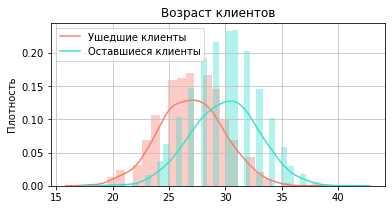

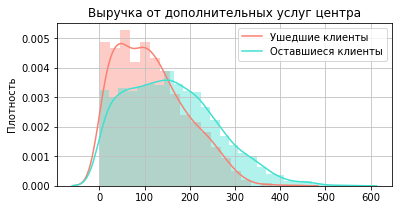

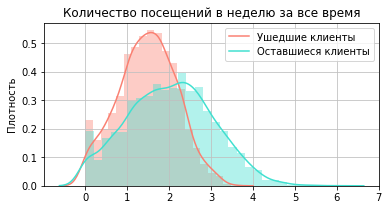

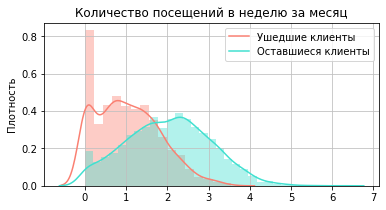

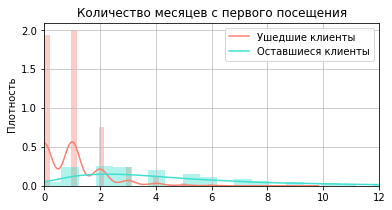

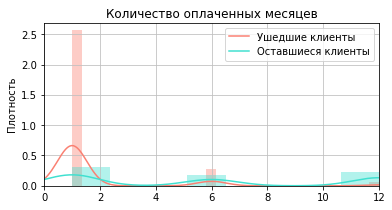

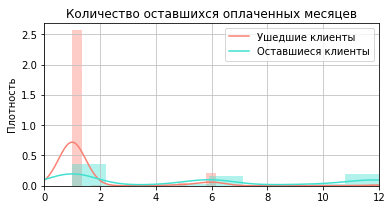

In [7]:
out_gym = gym[gym['churn']==1]
in_gym = gym[gym['churn']==0]
numeric_columns = ['age','avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime',  
                    'contract_period', 'month_to_end_contract']
for column in numeric_columns: 
    plt.figure(figsize=(6,3)) 
    sns.distplot(out_gym[column], color='salmon')
    sns.distplot(in_gym[column], color='turquoise')
    if column == 'age':
        plt.title('Возраст клиентов')
    if column == 'avg_additional_charges_total':
        plt.title('Выручка от дополнительных услуг центра')
    if column == 'avg_class_frequency_total':
        plt.title('Количество посещений в неделю за все время')
    if column == 'avg_class_frequency_current_month':
        plt.title('Количество посещений в неделю за месяц')  
    if column == 'lifetime':
        plt.title('Количество месяцев с первого посещения') 
        plt.xlim([0, 12])
    if column == 'contract_period':
        plt.title('Количество оплаченных месяцев')
        plt.xlim([0, 12])
    if column == 'month_to_end_contract':
        plt.title('Количество оставшихся оплаченных месяцев')
        plt.xlim([0, 12])    
    plt.grid(color='silver')
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.legend(['Ушедшие клиенты', 'Оставшиеся клиенты'])
    plt.show()

На графиках видим подтверждения ранее выдвинутым закономерностям, а именно:
* средний возраст оставшихся клиентов выше, чем средний возраст клиентов ушедших;
* дополнительная выручка с оставшихся клиентов выше, чем с клиентов с оттока;
* вполне логично что оставшиеся клиенты чаще посещали спортазал;
* за последний месяц очень много клиентов в оттоке, которые не посещали спортзал ни разу;
* большинство клиентов из оттока пришли в спортзал не позднее 2 месяцев назад;
* клиенты, которые не задерживаются в спортзале берут абонемент в основном на месяц;
* у большинства клиентов из оттока заканчивается абонемент через месяц.


Посмотрим теперь на графики с категориальными признаками. Где 0 - это оставшиеся клиенты, а 1 - ушедшие.

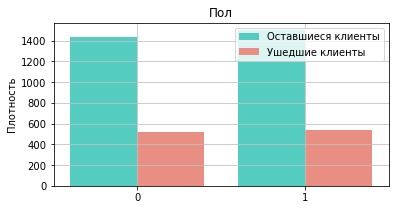

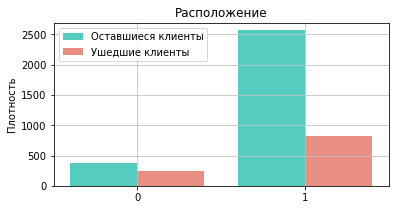

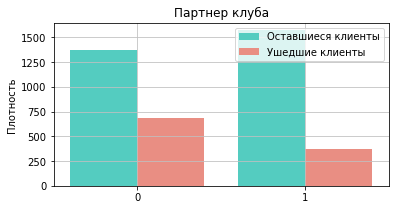

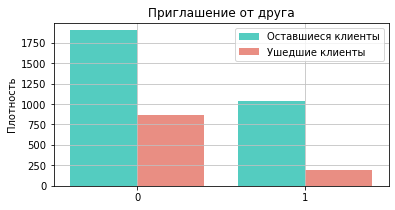

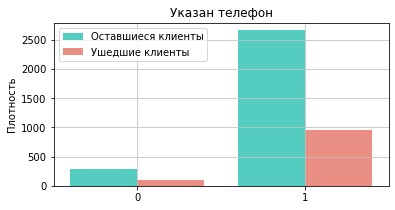

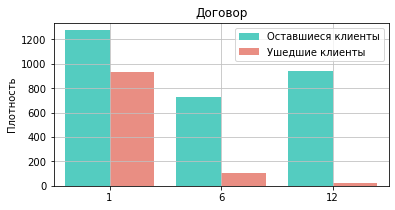

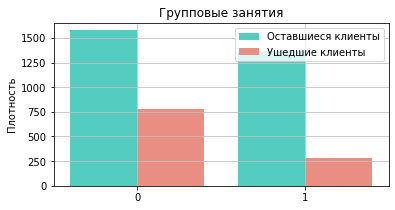

In [8]:
categorial_columns = ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits']
for column in categorial_columns: 
    plt.figure(figsize=(6,3)) 
    sns.countplot(gym[column], hue='churn', data=gym, palette=('turquoise', 'salmon'))
    if column == 'gender':
        plt.title('Пол')
    if column == 'near_location':
        plt.title('Расположение')
    if column == 'partner':
        plt.title('Партнер клуба')
    if column == 'promo_friends':
        plt.title('Приглашение от друга')
    if column == 'phone':
        plt.title('Указан телефон')
    if column == 'contract_period':
        plt.title('Договор')
    if column == 'group_visits':
        plt.title('Групповые занятия')    
    plt.grid(color='silver')
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
    plt.show()    

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

Отличный способ визуализации, в том числе можно было бы построить наши графики с помощью метода `subplots`, например в 2 колонки, для нашего удоства в их изучении.
    
Тут можно посмотреть примеры. 
    
- `matplotlib`: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html
- `plotly` : https://plotly.com/python/subplots/
    

</div>

Попытаемся выявить закономерности в категориальных признаках:


* пол - одинаковое распределение;
* cреди клиентов, живущих далеко от фитнес-центра, доля попавших в отток значительно выше, чем среди тех, кто живёт поблизости;
* Около половины клиентов, не работающих в компаниях-партнёрах (т.е. не имеющих постоянных скидок на абонемент), в итоге попали в отток. Доля ушедших в отток сотрудников компаний-партнёров значительно меньше(примерно 25-30 %).
* Доля клиентов, пришедших по акции "Приведи друга" попала в отток намного в меньшем количестве, чем доля ушедших клиентов без акции(примерно 20-25% против 45-50%).
* Наличие телефона в анкете практически не влияет на долю оттока.
* Больше всего клиентов, попавших в отток, среди тех, кто заключал договор на месяц(около 75%). Около 15-20% в отток попадает клиентов, которые заключают договор на пол года. Реже остальных попадают в отток клиенты с 12-месячными абонементами.
* Люди, посещающие групповые программы, реже попадают в отток. Примерно половина клиентов которые не приходят на групповые занятия покидают спорт-клуб.


### Построим матрицу корреляций и отобразим её

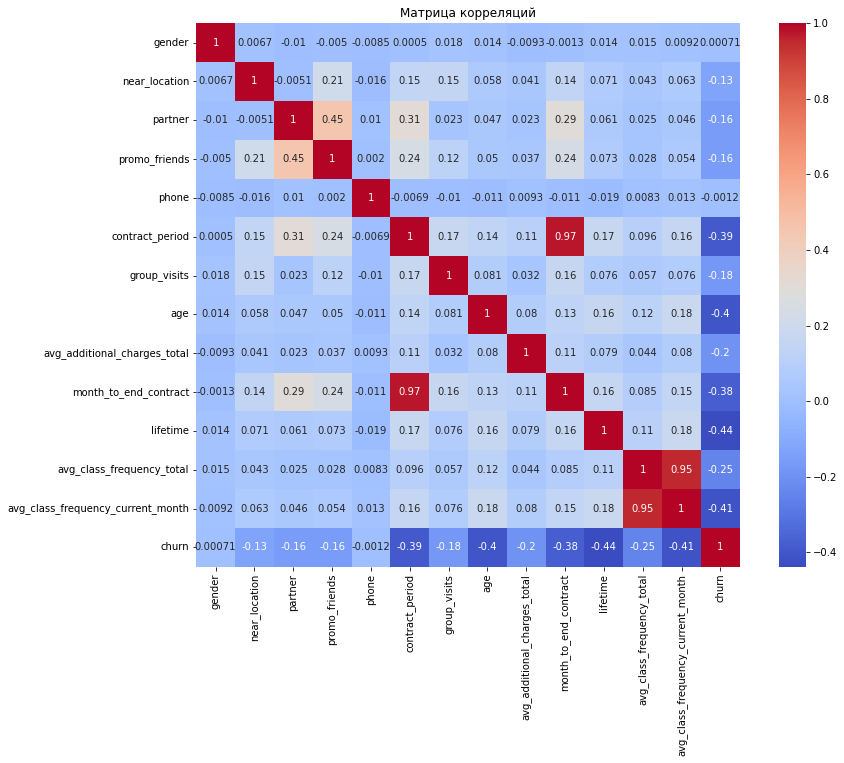

In [9]:
plt.figure(figsize=(14,10))
sns.heatmap(data = gym.corr(), annot=True, square=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

На тепловой карте видим, что корреляции есть только между очевидно-зависящими друг от друга признаками. А именно:
* срок действия абонимента и срок до окончания действия абонемента;
* среднее количество посещений за все время и среднее количество посещений за последний месяц.

**Избавимся от по одному из этих признаков, т.к. мультиколлинеарность может повлиять на результаты моделей.**

In [10]:
gym = gym.drop(columns=['contract_period', 'avg_class_frequency_total'])

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

Действительно у нас есть сильная корреляция между несколькими переменными  и это говорит о мультиколлениарности.
    
Здорово, что мы избавились от некоторых столбцов 👍
    
</div>

## Построим модель прогнозирования оттока клиентов

### Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце: 1. Разделим данные на обучающую и валидационную выборку.

In [11]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(columns=['churn'])
y = gym['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

    
В целом выборка разделена верно. 
Я бы рекомендовал бы ещё использовать атрибут `stratify`, поместив в него целевую переменную. Он дает нам безопасность сохранения 20% значений равного нужного нам количества классов в целевой переменной.
    
Пример: `stratify=y`
    
---
    
Хорошо, что используем параметр `random_state`, чтобы получать одни и те же результаты.
    
</div>

### Обучим модель на train-выборке двумя способами:

#### Логистическая регрессия

In [12]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print('accuracy_score: {:.2f}\nprecision_score: {:.2f}\nrecall_score:{:.2f}'.format(
    accuracy_score(y_test, lr_predictions),
    precision_score(y_test, lr_predictions),
    recall_score(y_test, lr_predictions)))

accuracy_score: 0.91
precision_score: 0.80
recall_score:0.82


#### Случайный лес

In [13]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('accuracy_score: {:.2f}\nprecision_score: {:.2f}\nrecall_score:{:.2f}'.format(
    accuracy_score(y_test, rf_predictions),
    precision_score(y_test, rf_predictions),
    recall_score(y_test, rf_predictions)))

accuracy_score: 0.91
precision_score: 0.82
recall_score:0.78


<div class="alert alert-warning">
<b>Комментарий ревьюера: ❗️</b>

    
Кстати можно было бы сделать функцию для расчетов метрик, тем самым оптимизировать наш код.   
</div>

### Выводы:

* Доля правильных ответов (accuracy_score) одинакова для обеих моделей - 92%. 
* Точность (precision_score) незначительно выше у модели случайный лес чем у логической регрессии (82% и 80% соответственно).
* Полнота (recall_score) в модели логистической регрессии равна 82%, а в в модели случайный лес 78%.

**Таким образом, модель логической регрессии в данном случае показала несколько лучшие результаты, чем модель случайный лес.**

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>
   
Обрати внимание, что все рассчитанные метрики по отдельности сложны в интерпритации, хотелось чтобы одна метрика включала в себя самые ключевые параметры. Есть метрика `F1`, которая как раз включает в себя основные параметры точности и полноты. 
    
В том числе рекомендую смотреть на метрику `ROC–AUC`. 
    
    
Ниже статья, в которой есть материалы про метрики и как их визуализировать.
    
https://habr.com/ru/company/ods/blog/328372/
    
---

Можно также попробовать и сравнить параметр `C` у логистической регрессии. У случайного леса количество деревьев (`n_estimators`) и максимальную глубину дерева (`max_depth`), чтобы осуществить поиск лучшей модели.
    
---
    
Кстати для автоматического перебора гиперпараметров мы можем использовать готовый метод `GreadSearchCV` в библиотеке `sklearn`. 
    
</div>

## Кластеризация

### Стандартизируем данные. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

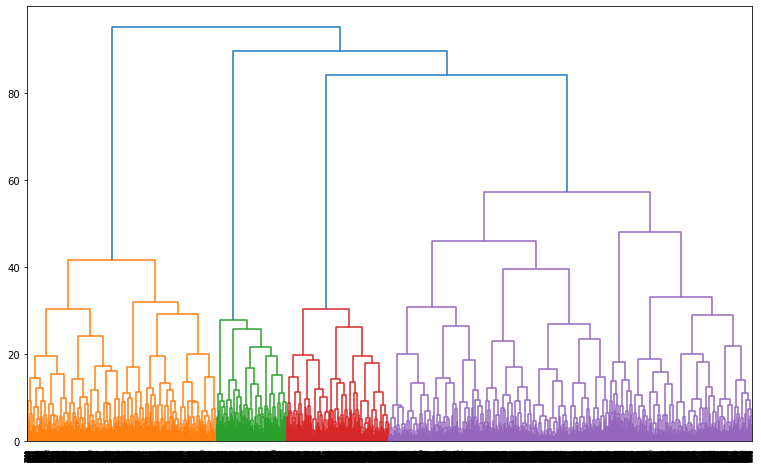

In [14]:
# Выделим данные для кластеризации:
X = gym.drop('churn', axis = 1)

# Стандартизируем:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Строим таблицу расстояний между объектами:
linked = linkage(X_sc, method = 'ward') 

# Визуализируем (строим дендрограмму):
plt.figure(figsize=(13, 8))  
dendrogram(linked, orientation='top')
plt.show() 

Построенная дендограмма делит клиентов на 4 кластера (т.к у нас 4 разных цвета). По требованиям мы должны поделить клиентов на 5 групп.

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>
    
Отлично 👍

В том числе чтобы определить количество кластеров можно использовать метод локтя. 
    
Ниже статья с двумя методами, которые можно в том числе использовать для определения количества кластеров.
    
https://habr.com/ru/company/jetinfosystems/blog/467745/
    
</div>

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [15]:
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [16]:
gym['cluster_km'] = labels #сохраняем метки кластера в поле нашего датасета
gym.groupby('cluster_km').agg('mean').T 

cluster_km,0,1,2,3,4
gender,0.492000,0.495352,0.511194,0.502455,0.550481
near_location,0.994000,0.998672,1.000000,0.000000,0.998798
partner,0.953000,0.378486,0.226368,0.489362,0.274038
promo_friends,1.000000,0.046481,0.114428,0.072013,0.075721
phone,0.906000,0.903054,0.899254,0.913257,0.897837
group_visits,0.528000,0.000000,0.182836,0.232406,1.000000
age,29.633000,30.342629,26.807214,28.700491,30.248798
avg_additional_charges_total,154.086252,174.392898,111.073289,137.375245,155.206260
month_to_end_contract,6.730000,4.698539,1.715174,2.826514,4.707933
lifetime,4.287000,5.166003,1.420398,3.027823,4.483173


<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>

Супер, теперь у нас есть портреты наших пользователей 👍
    
</div>

Посмотрим какие признаки объединяют каждый кластер:

**Кластер "0":**
- Клиенты этого кластера живут/работают недалеко от клуба;
- *95% клиентов имеют скидки как сотрудники компании-партнера;*
- **Все клиенты пришли по приглашению друга;**
- Половина из них посещают групповые занятия;
- Средний возраст - 29-30 лет;
- Средний период до окончания абонемента 6-7 месяцев;
- **2 посещения в неделю;**
- Отток 10%.

**Кластер "1":**
- Почти все клиенты также живут/работат недалеко от центра;
- 38% клиентов имеют скидки т.к. работают в компании-партнере;
- **НЕ посещают групповые занятия;**
- Возраст - 30 лет;
- До окончания контракта в среднем 4-5 месяцев;
- *Средний срок с первого посещения больше 5 месяцев;*
- **Лучшая посещаемость из всех кластеров;**
- Отток около 5%.

**Кластер "2":**
- **Абсолютно все клиенты работают/живут недалеко от клуба;**
- *23% клиентов имеют скидки как сотрудники компании-партнера;*
- **Средний возраст 26-27 лет**;
- Окончание абонемента через 2 месяца;
- **Меньше всех знакомы по времени с клубом;**
- В среднем 1 посещение в месяц;
- **Отток 74%**

**Кластер "3":**
- **Никто из клиентов не привязан к району в котором находится клуб;**
- 49% работают в компании-партнере клуба;
- Окончание абонемента через 3 месяца;
- Посещений в неделю в среднем ближе к 2;
- **Отток 40%**

**Кластер "4":**
- Почти все клиенты также живут/работат недалеко от центра;
- **Все клиенты посещают групповые занятия;**
- Средний возраст - 30 лет;
- До окончания абонемента в среднем почти 5 месяцев;
- **2 посещения в неделю**;
- Отток 9%.

### Построим распределения признаков для кластеров

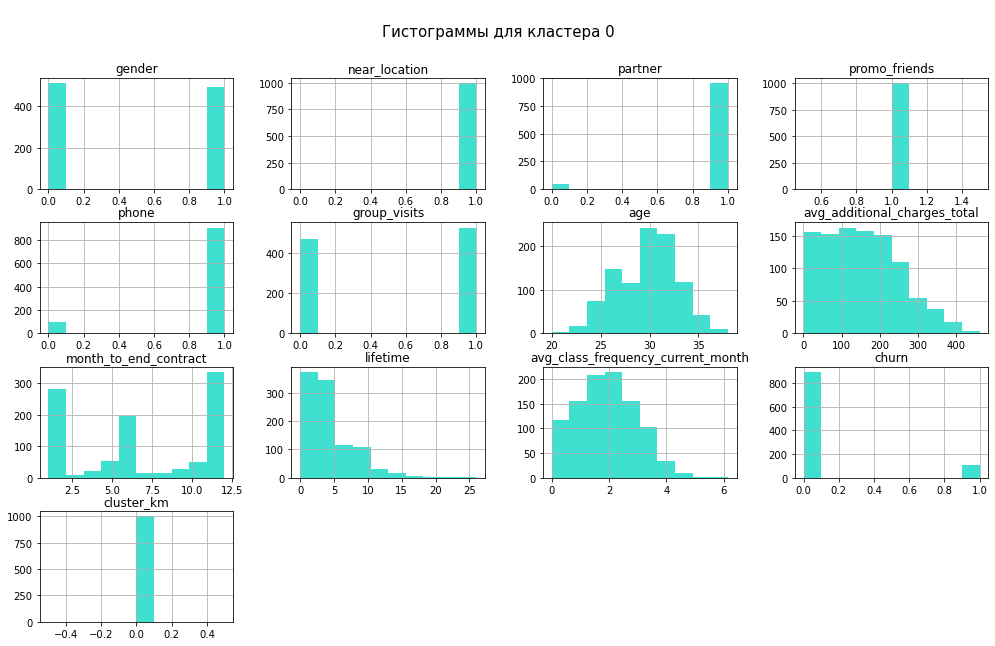

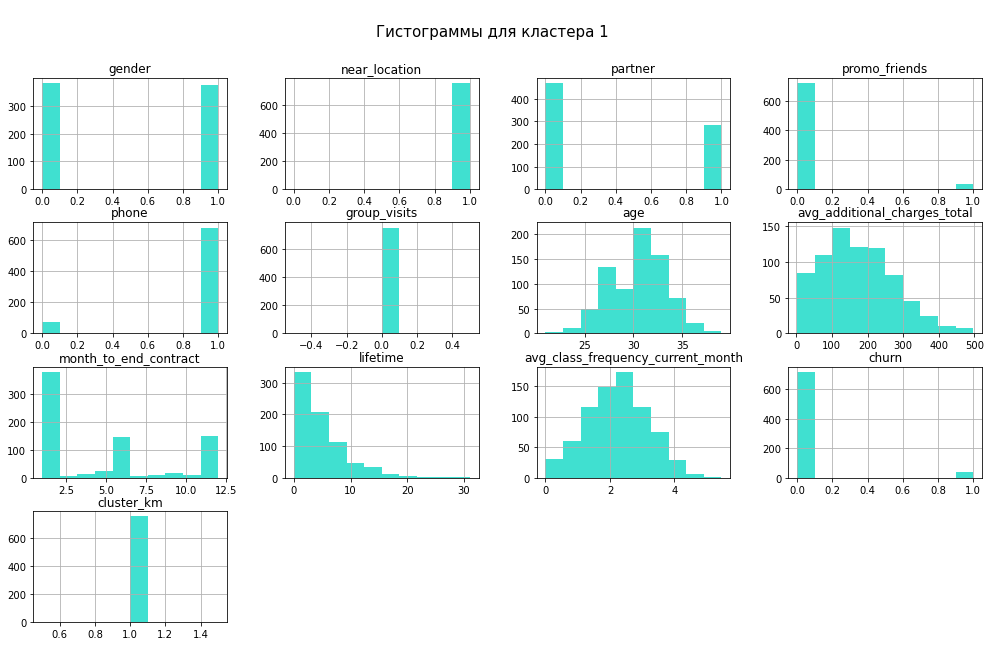

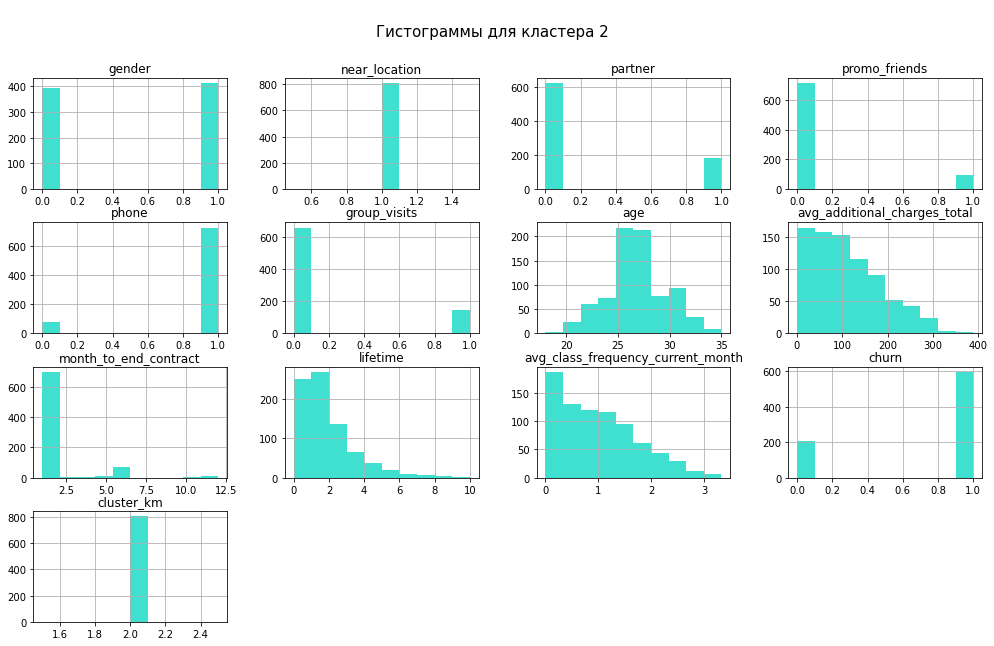

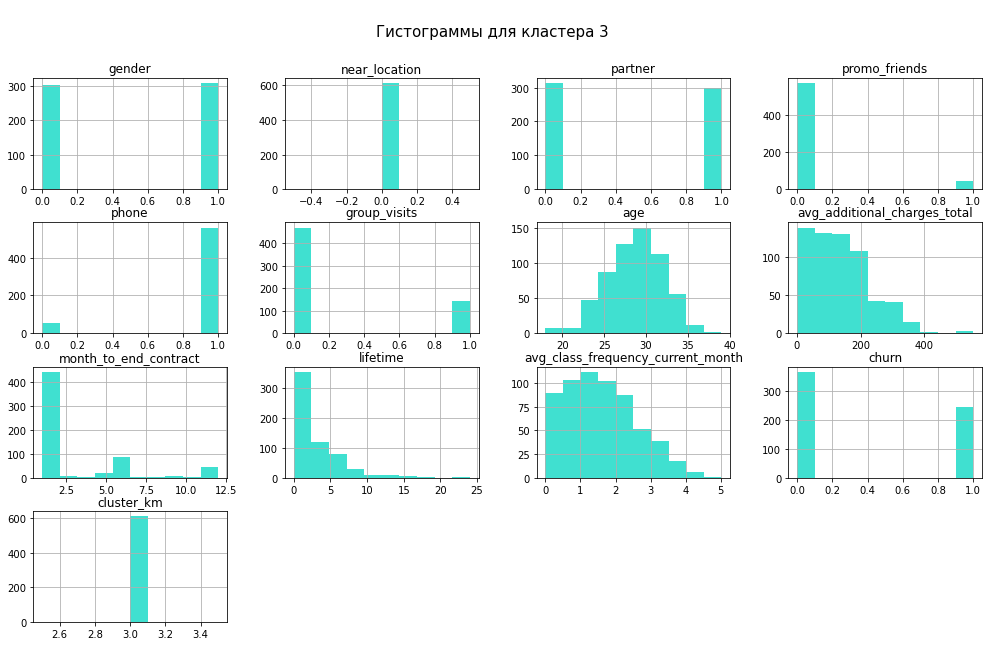

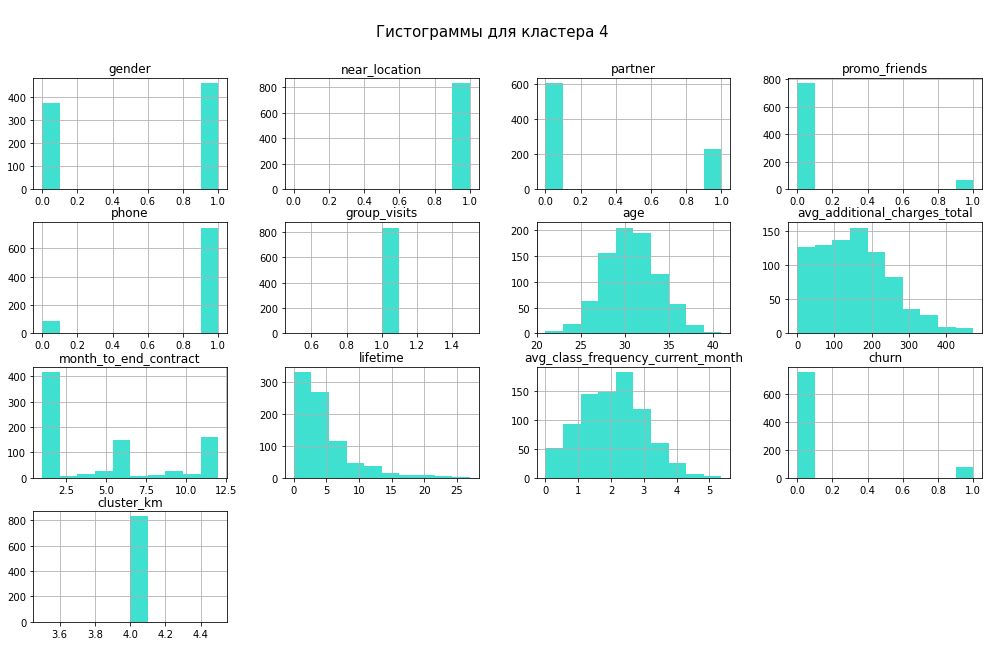

In [17]:
for сlaster in [0, 1, 2, 3, 4]:
    gym[gym['cluster_km']==сlaster].hist(figsize=(17,10), color='turquoise')
    plt.suptitle('\nГистограммы для кластера {}'.format(сlaster), fontsize = 15)
    plt.show()

Все вышеописанные признаки для кластеров по таблице целиком и полностью коррелируют с графиками.

### Для каждого полученного кластера посчитаем процент оттока 

In [18]:
churn_percent = gym.groupby('cluster_km')['churn'].agg('sum') / gym.groupby('cluster_km')['churn'].size() * 100
churn_percent

cluster_km
0    10.800000
1     4.648074
2    74.129353
3    40.098200
4     9.254808
Name: churn, dtype: float64

Самыми надежными являются кластеры 0, 1, 4, в них самый маленький процент оттока. Самым ненадежным является кластер 2 - из него уходят 74% клиентов.

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>
    
Думаю, теперь у коллег из маркетинга будет много дополнительной информации, которую они смогут использовать при разработке дополнительных мероприятий по сокращению оттока.
</div>

## Вывод и рекомендации:

Каких либо явных признаков для того чтобы уменьшить отток не обнаружено.

Очевидно, что люди реже бросают спортзал, если живут/работают в другом районе. Для таких клиентов можно сделатть какой-нибудь дополнительный бонус, хотя обычно бонусы дают тем, кто живет близко.

Также редко уходят люди, у которых взят абонемент на долгий срок, но убирать месячный абонемент нецелесообразно, он должен быть в каждом зале, чтобы клиент успел понять какие есть у зала плюсы и минусы. Можно попробовать месячный абонемент заменить на полуторомесячный или на 5-6 недельный, возможно потраченные деньги клиента на больший период побудят его сходить в зал чаще и найти в нем преимущества для себя и возможно завести новых друзей. 

Акция "приведи друга" хорошо работает в корреляции с признаком для клиентов, у которых есть скидка от компании-партнера, скорее всего эти акции распространяются в основном на коллег. 

Участие в групповых занятиях тоже дает хорошие результаты по количеству оттока, опять же возможно коллегам нравится заниматься вместе, или клиенты зала чувствуют большую ответственность и заинтересованность в коллективных занятиях. 

В общем и целом есть клиенты, которые живут далеко, не ходят на групповые занятия, покупают абонементы на короткий период и не тратят деньги на доп. услуги(возможно они просто о них не знают, например о массажном и косметическом салоне)и именно эти признаки на мой взгляд нужно проработать. Люди любят акции, скидки и выгоду, даже если надуманы. И здесь многое зависит от самого зала и его бюджета, т.е. есть ли у зала финансы для того чтобы придумать акции и скидки для категорий, которые чаще оказываются в оттоке или нет. Также частично отток может зависеть от работников заведения, которые умеют заинтересовать клиентов и ненавязчиво рассказать о всех выгодах и прелестях посещения именно этого зала или ее сети.

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>
    


Выводы понятны и логичны, а самое главное подкреплены выявленными фактами.
       
В целом сам проект выполнен на хорошем уровне! На протяжении всей работы чувствуется глубина проработки задачи и это безусловный плюс для нас. Было использовано большое количество методов, которые будут помогать тебе в дальнейших проектах.
        
    
    
Если вдруг будет дополнительный интерес по осовоению дополнительных материалов этой темы, вот достаточно неплохая информация по базовым алгоритмам:
    
https://compscicenter.ru/courses/data-mining-python/2018-spring/classes/
    
P.s. Там несколько курсов, по которым можно будет пройтись при желании 😊

    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера: ✅</b>
    

Возвращаю проект обратно, чтобы убедиться что все мои комментарии понятны.
    
Если вдруг у тебя возникнут какие-то вопросы, то я с радостью отвечу на них 😊
    
</div>